<a href="https://colab.research.google.com/github/Matsuda-K/tutorial/blob/main/Excursion_sweets_300yen_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# お菓子選択問題を量子アニーリングによって解く

- ここでは、小学生時代に誰しもが経験したことがあるであろう遠足に持っていくお菓子選択問題を量子アニーリングによって解く
- 先生、お決まりのセリフ「**おやつは300円まで！**」
 ⇒ 制約があるため、お菓子の取捨選択をする必要がある
- **予算300円の範囲内で、満足度が最大化されるお菓子の組合せ**を考える
 ※ただし、各お菓子は1個のみ持っていけると仮定

## 問題設定

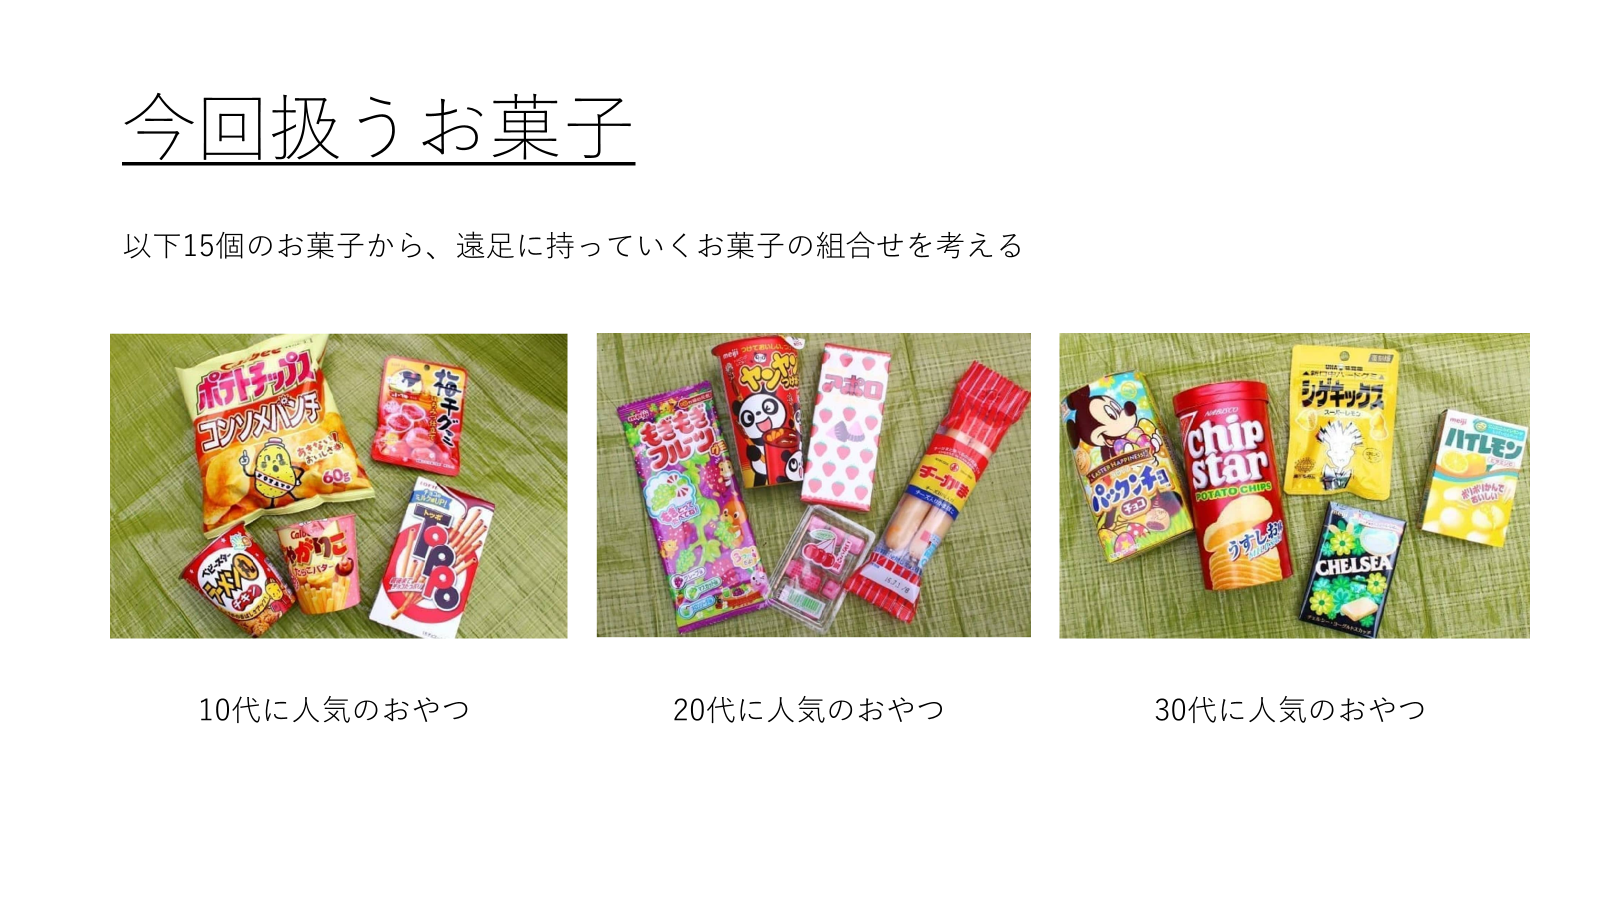

In [ ]:
P = 300 # 先生から指定されたお菓子の予算
sweets = {0:'ポテトチップス コンソメパンチ', 1:'梅干グミ', 2:'ベビースターラーメン丸 チキン', 3:'じゃがりこ たらこバター', 4:'トッポ', 5:'もぎもぎフルーツ(グミ)', 6:'ヤンヤンつけボー', 7:'アポロ', 8:'こざくら餅', 9:'チーかま', 10:'パックンチョ', 11:'チップスター', 12:'シゲキックス スーパーレモン', 13:'チェルシー ヨーグルトスカッチ', 14:'ハイレモン'} # お菓子の名称
p = {0:138, 1:138, 2:112, 3:127, 4:116, 5:160, 6:160, 7:123, 8:35, 9:170, 10:84, 11:156, 12:135, 13:154, 14:135} # 値段
s = {0:9, 1:3, 2:6, 3:8, 4:10, 5:5, 6:4, 7:7, 8:3, 9:8, 10:7, 11:10, 12:9, 13:4, 14:8} # 満足度
N = len(s) # 個数

In [ ]:
d = {}
for i in range(N):
  d[sweets[i]] = [p[i], s[i]]

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(d, orient="index")
df.columns = ['値段', '満足度']
df

,値段,満足度
ポテトチップス コンソメパンチ,138,9
梅干グミ,138,3
ベビースターラーメン丸 チキン,112,6
じゃがりこ たらこバター,127,8
トッポ,116,10
もぎもぎフルーツ(グミ),160,5
ヤンヤンつけボー,160,4
アポロ,123,7
こざくら餅,35,3
チーかま,170,8


## QUBO定式化

In [ ]:
!pip install pyqubo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.4 MB/s eta 0:00:00


In [ ]:
from pyqubo import Array, LogEncInteger

x = Array.create('x', shape = (N), vartype = 'BINARY') # 決定変数
z = LogEncInteger("z", (0, P)) # スラック変数

In [ ]:
from pyqubo import Constraint
from pyqubo import solve_qubo
import dimod
import math

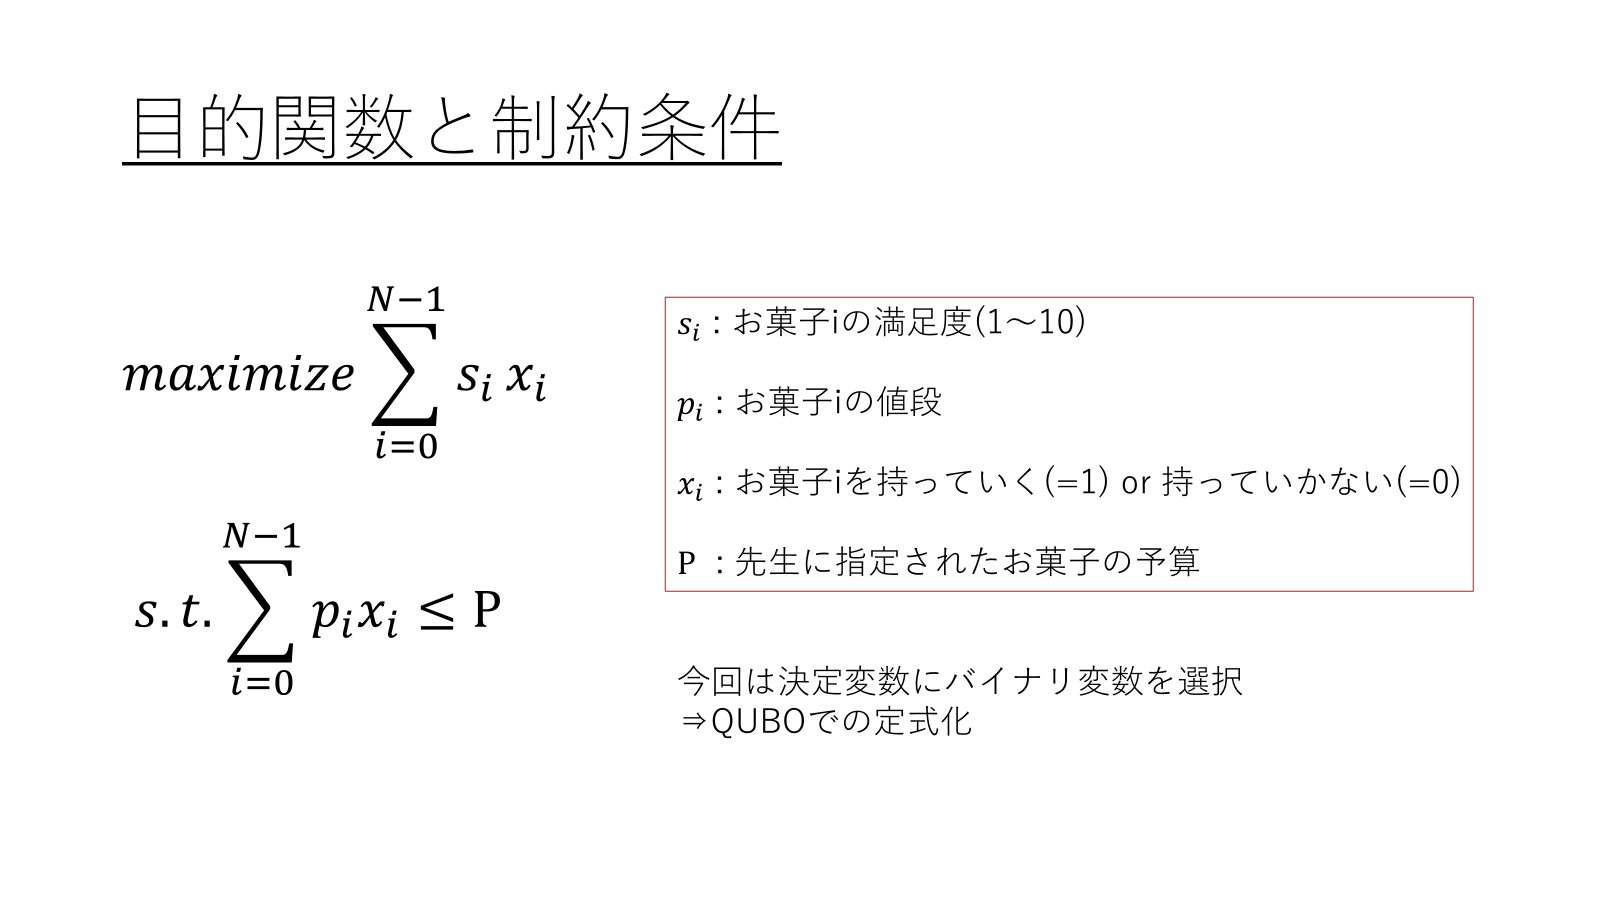

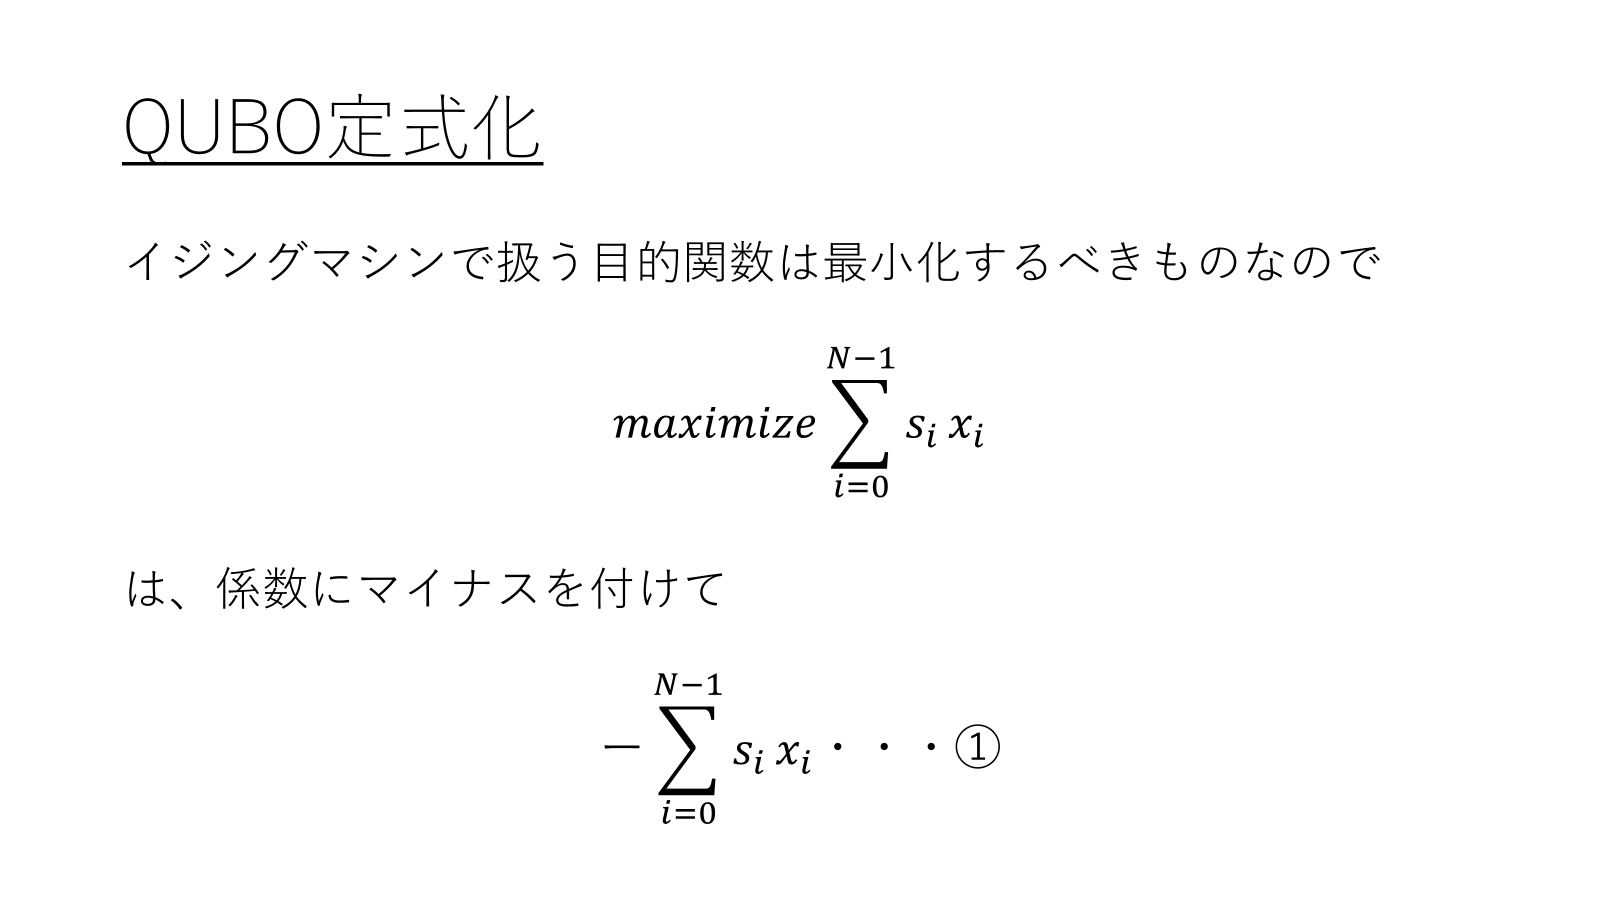

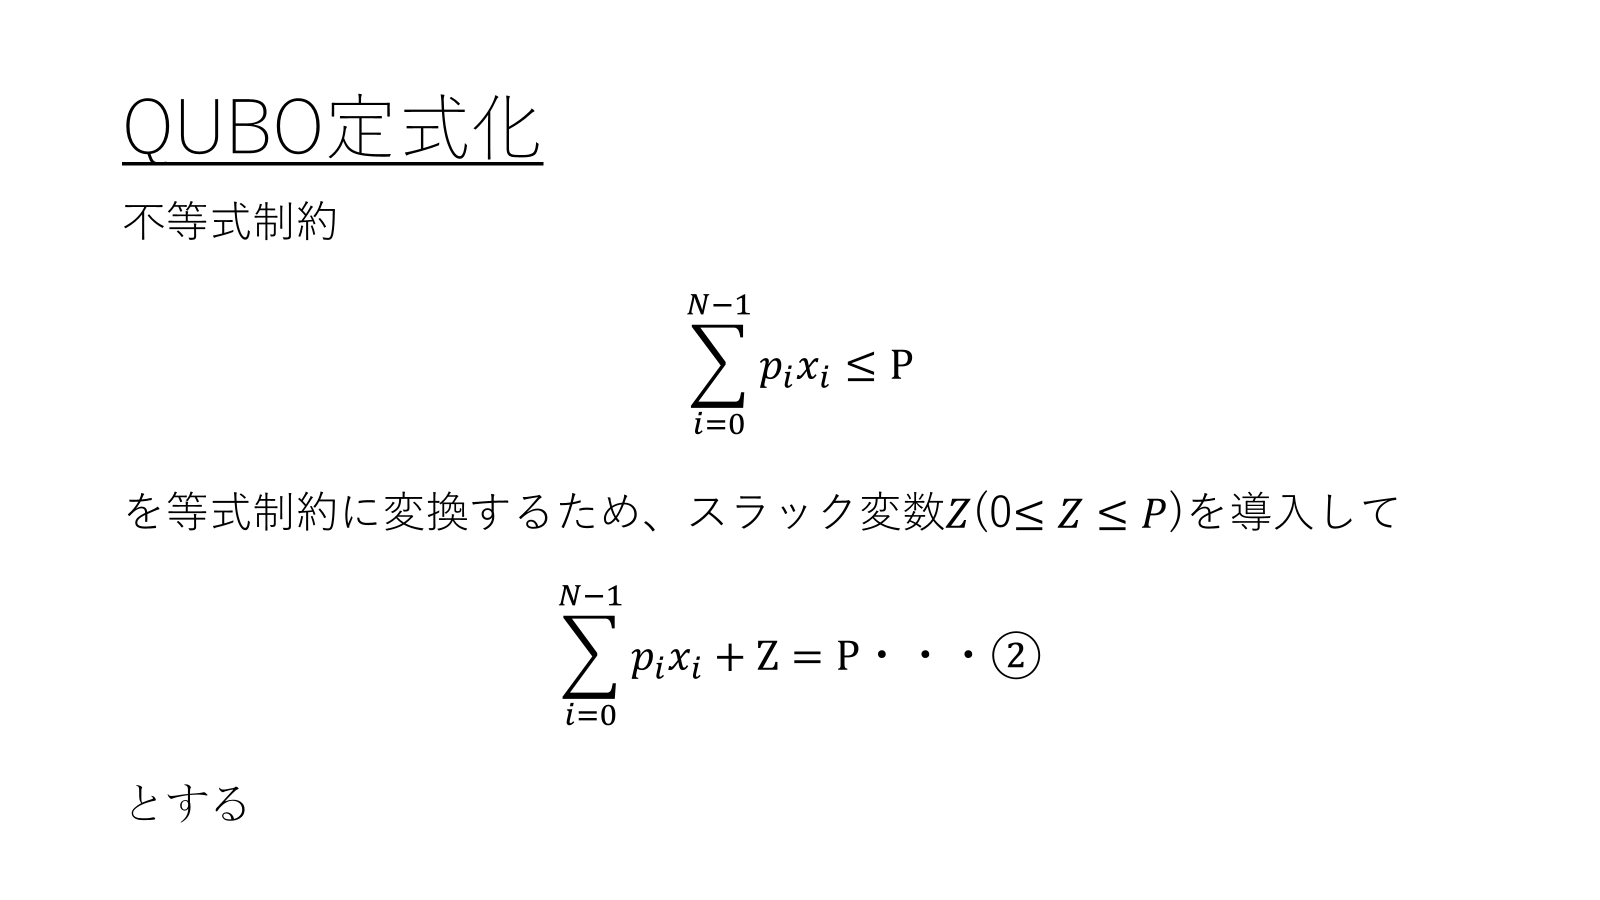

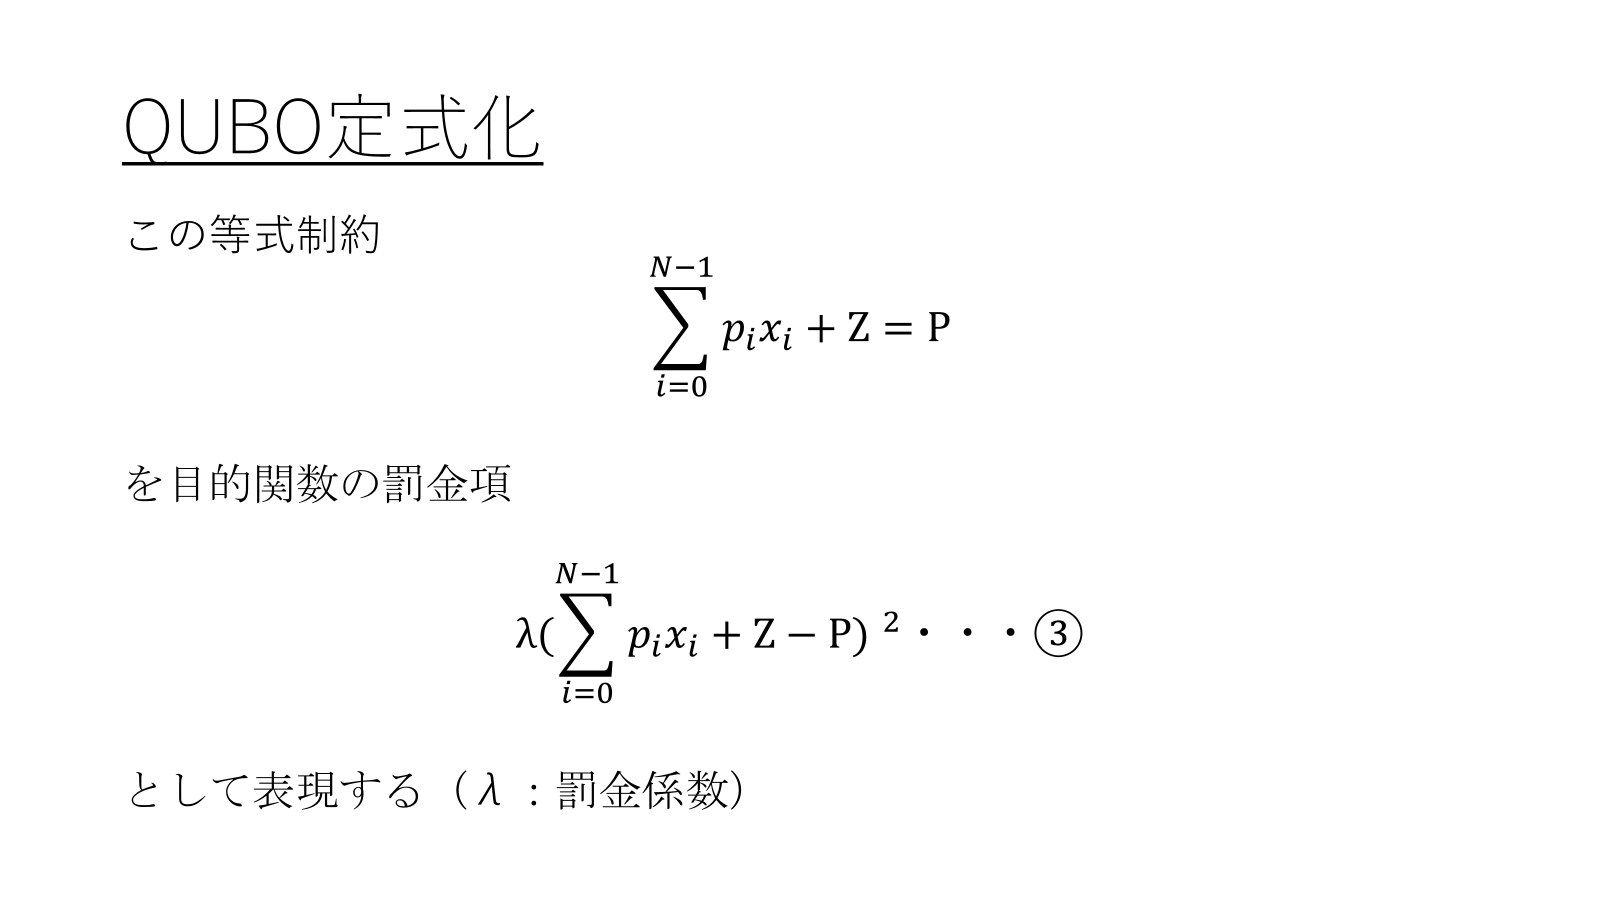

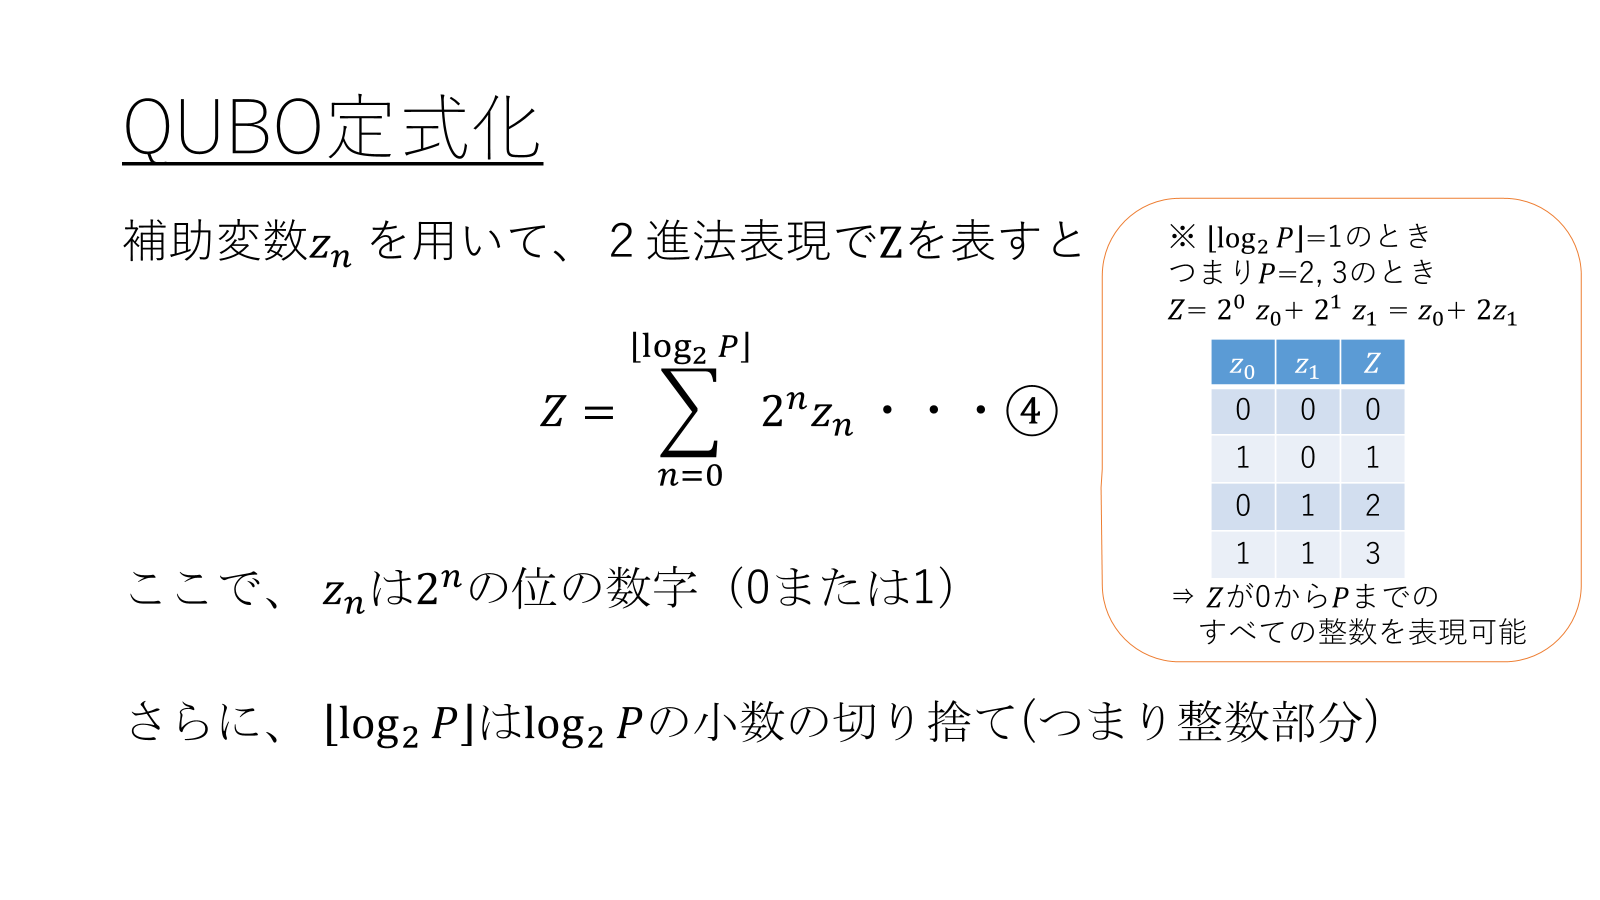

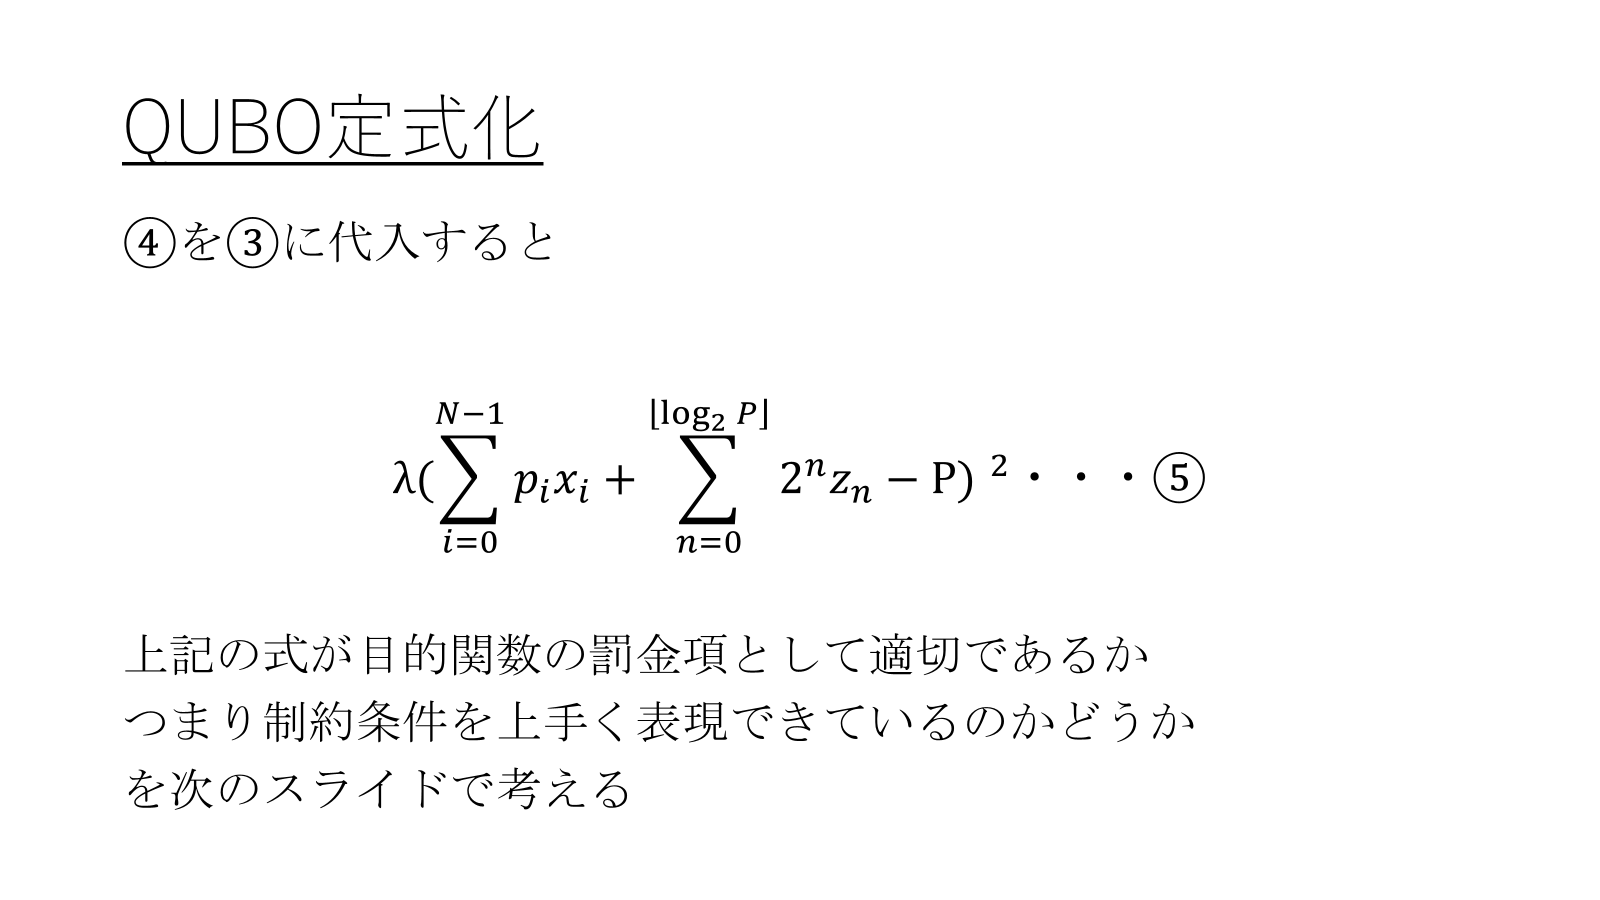

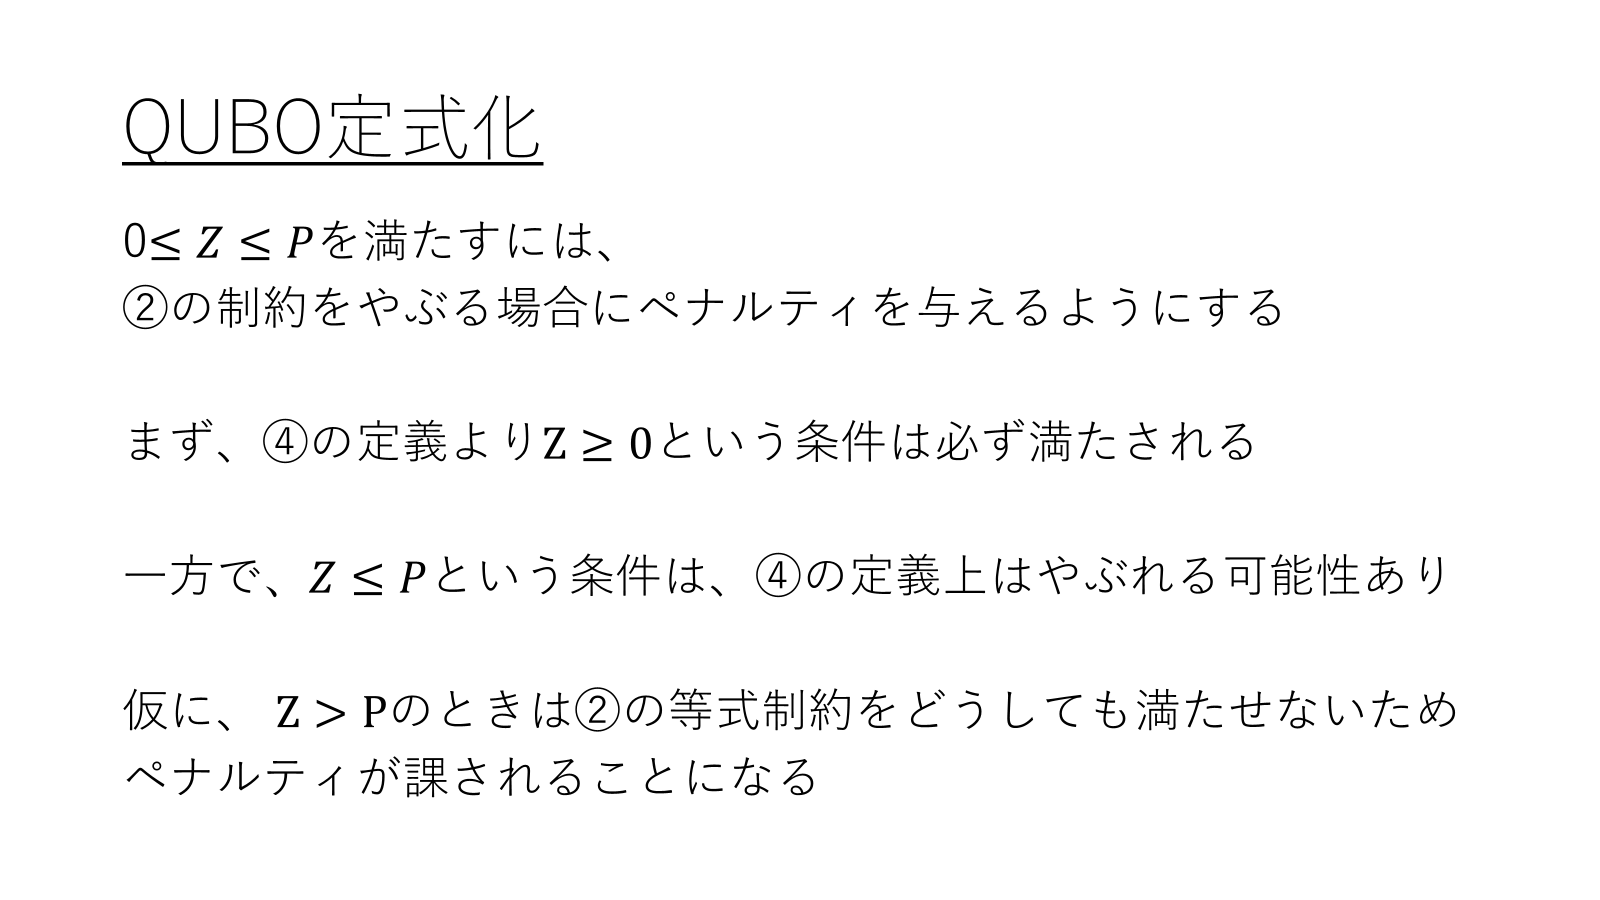

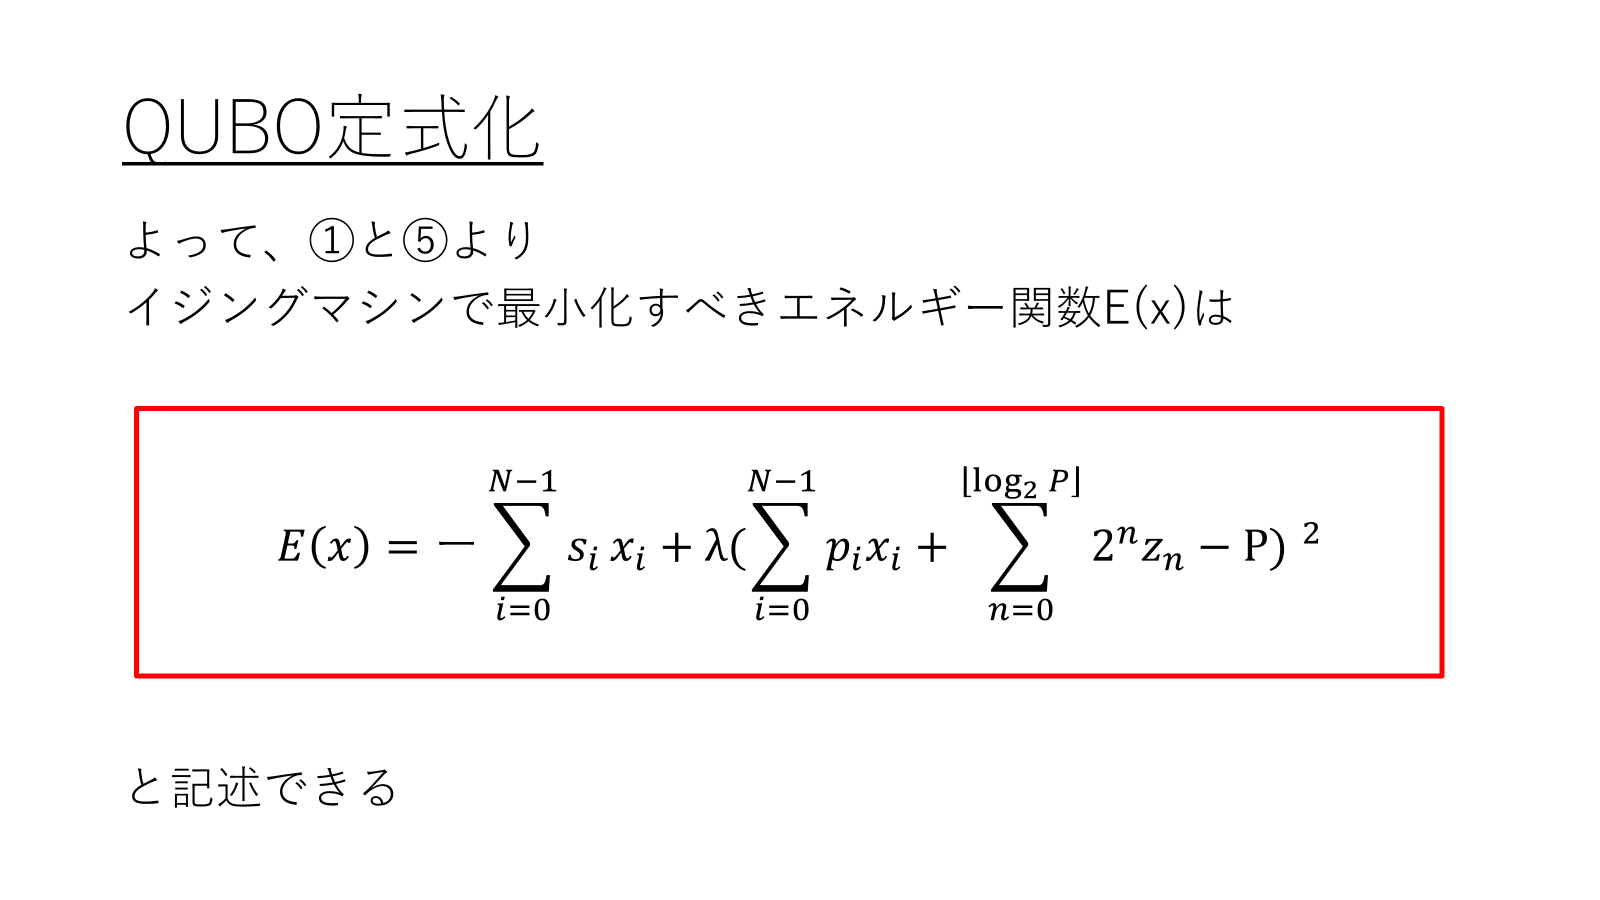

## 実行結果

In [ ]:
def print_results(lam):
  print("[Inputs]")

  print(f'\nお菓子の予算:{P}円')
  print(f"お菓子の個数:{N}個")

  print("\nお菓子の満足度リスト")
  print(s)

  print("\nお菓子の価格リスト")
  print(p)

  print('\n罰金係数λ')
  print(lam)

  # QUBO定式化
  HA = Constraint(
    lam * (sum(p[i] * x[i] for i in range(N)) + z - P) ** 2,
    label = 'HA'
  )

  HB = -1 * sum(s[i] * x[i] for i in range(N))

  Q = HA + HB
  model = Q.compile()
  q, offset = model.to_qubo()

  # 指定したソルバーで問題を解く
  sampleset = dimod.ExactSolver().sample_qubo(q)
  decoded_sample  = model.decode_sample(sampleset.first.sample, vartype="BINARY")

  print("\n[Results]")

  # 実行結果（決定変数の値）
  print("decoded_sample.sample")
  print(decoded_sample.sample)

  print("\n持っていくお菓子")

  sweet = [v for k, v in sweets.items()]
  satisfication = 0
  price = 0

  for k in range(N):
    if decoded_sample.array('x', k) != 0:
        print(sweets[k])
        satisfication += s[k]
        price += p[k]


  sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('z', elem)) for elem in range(math.ceil(math.log2(P)))])

  print("\nスラック変数 = {}".format(sol_y))

  # 制約違反チェック
  print("\nbroken")
  print(decoded_sample.constraints(only_broken=True))

  print(f"満足度の合計 : {satisfication}")
  print(f"価格の合計 : {price}円")

In [ ]:
# 罰金係数が10のとき
print_results(10)

[Inputs]

お菓子の予算:300円
お菓子の個数:15個

お菓子の満足度リスト
{0: 9, 1: 3, 2: 6, 3: 8, 4: 10, 5: 5, 6: 4, 7: 7, 8: 3, 9: 8, 10: 7, 11: 10, 12: 9, 13: 4, 14: 8}

お菓子の価格リスト
{0: 138, 1: 138, 2: 112, 3: 127, 4: 116, 5: 160, 6: 160, 7: 123, 8: 35, 9: 170, 10: 84, 11: 156, 12: 135, 13: 154, 14: 135}

罰金係数λ
10

[Results]
decoded_sample.sample
{'z[6]': 0, 'z[7]': 0, 'z[5]': 0, 'z[3]': 1, 'z[0]': 0, 'z[8]': 0, 'x[8]': 1, 'x[7]': 0, 'z[1]': 1, 'x[5]': 0, 'x[4]': 1, 'x[2]': 0, 'z[4]': 0, 'x[1]': 0, 'x[14]': 0, 'z[2]': 1, 'x[3]': 0, 'x[13]': 0, 'x[12]': 1, 'x[9]': 0, 'x[6]': 0, 'x[11]': 0, 'x[10]': 0, 'x[0]': 0}

持っていくお菓子
トッポ
こざくら餅
シゲキックス スーパーレモン

スラック変数 = 14

broken
{}
満足度の合計 : 22
価格の合計 : 286円


In [ ]:
# 罰金係数のチューニング
for lam in range(1, 20, 3):
  print_results(lam)
  print('\n' * 3)

[Inputs]

お菓子の予算:300円
お菓子の個数:15個

お菓子の満足度リスト
{0: 9, 1: 3, 2: 6, 3: 8, 4: 10, 5: 5, 6: 4, 7: 7, 8: 3, 9: 8, 10: 7, 11: 10, 12: 9, 13: 4, 14: 8}

お菓子の価格リスト
{0: 138, 1: 138, 2: 112, 3: 127, 4: 116, 5: 160, 6: 160, 7: 123, 8: 35, 9: 170, 10: 84, 11: 156, 12: 135, 13: 154, 14: 135}

罰金係数λ
1

[Results]
decoded_sample.sample
{'z[6]': 0, 'z[7]': 0, 'z[5]': 0, 'z[3]': 1, 'z[0]': 0, 'z[8]': 0, 'x[8]': 1, 'x[7]': 0, 'z[1]': 1, 'x[5]': 0, 'x[4]': 1, 'x[2]': 0, 'z[4]': 0, 'x[1]': 0, 'x[14]': 0, 'z[2]': 1, 'x[3]': 0, 'x[13]': 0, 'x[12]': 1, 'x[9]': 0, 'x[6]': 0, 'x[11]': 0, 'x[10]': 0, 'x[0]': 0}

持っていくお菓子
トッポ
こざくら餅
シゲキックス スーパーレモン

スラック変数 = 14

broken
{}
満足度の合計 : 22
価格の合計 : 286円






[Inputs]

お菓子の予算:300円
お菓子の個数:15個

お菓子の満足度リスト
{0: 9, 1: 3, 2: 6, 3: 8, 4: 10, 5: 5, 6: 4, 7: 7, 8: 3, 9: 8, 10: 7, 11: 10, 12: 9, 13: 4, 14: 8}

お菓子の価格リスト
{0: 138, 1: 138, 2: 112, 3: 127, 4: 116, 5: 160, 6: 160, 7: 123, 8: 35, 9: 170, 10: 84, 11: 156, 12: 135, 13: 154, 14: 135}

罰金係数λ
4

[Results]
decoded_sample.sample


実行結果をまとめると...

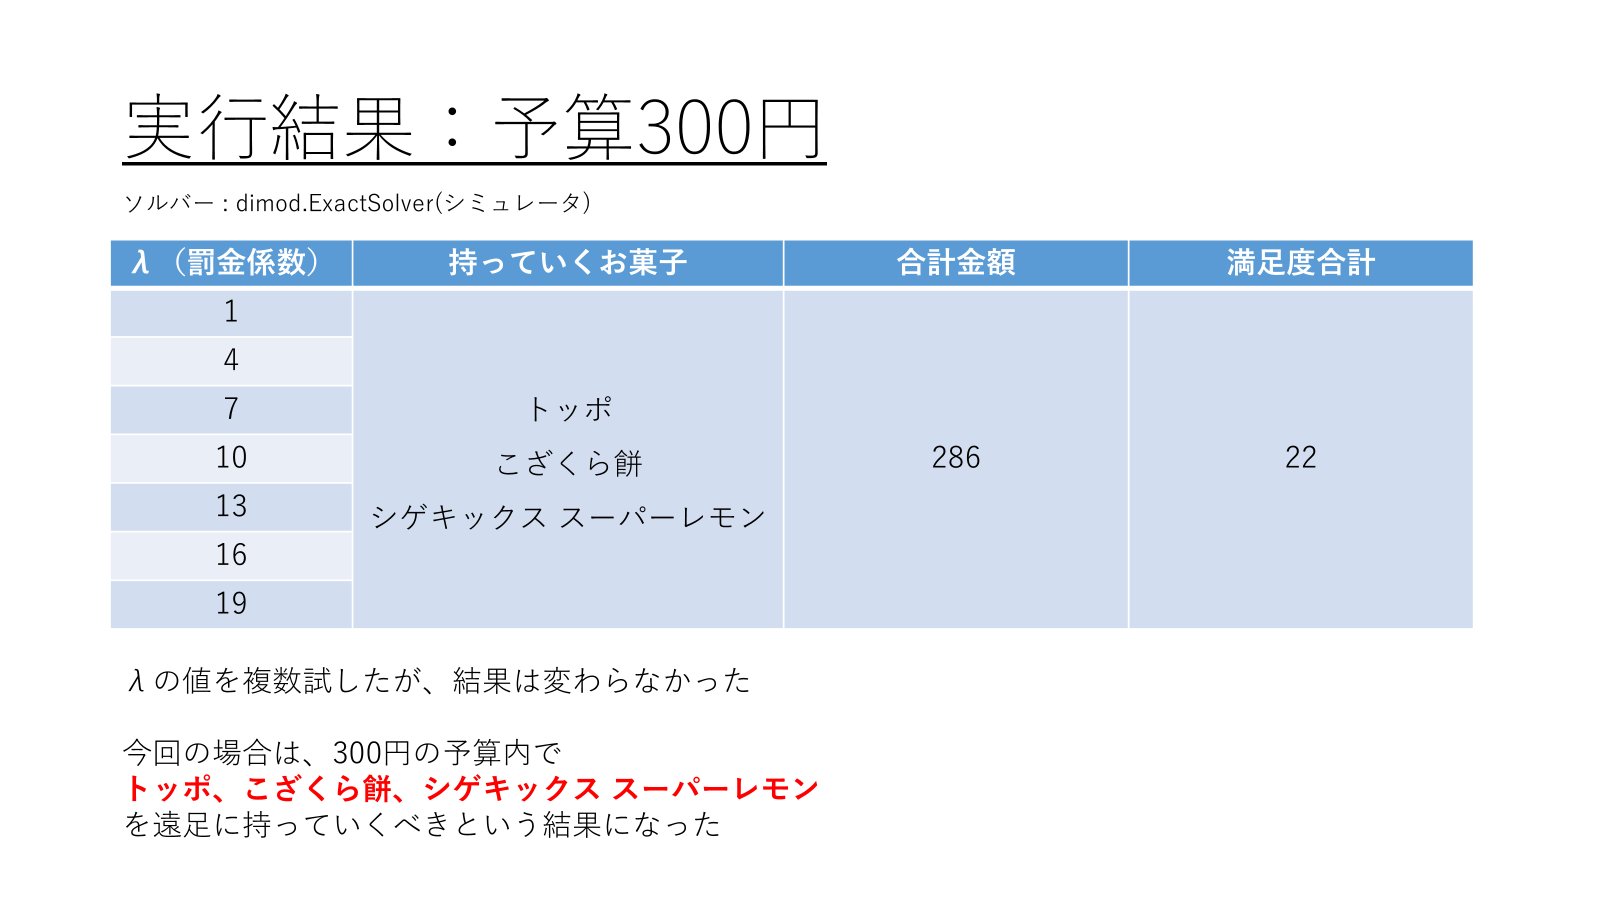